In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import datasets, transforms


In [3]:
ROOT = pathlib.Path("./train_images")

patterns = ["*.jpg","*.JPG","*.jpeg","*.JPEG","*.png","*.PNG"]
all_imgs = []
for pat in patterns:
    all_imgs.extend(ROOT.rglob(pat))

df = pd.DataFrame({"filepath": sorted(all_imgs)})
df["label"] = df["filepath"].apply(lambda p: p.parent.name)
print(df.shape, "images across", df["label"].nunique(), "classes")
df.head()


(20814, 2) images across 10 classes


,filepath,label
0,train_images\bacterial_leaf_blight\100023.jpg,bacterial_leaf_blight
1,train_images\bacterial_leaf_blight\100023.jpg,bacterial_leaf_blight
2,train_images\bacterial_leaf_blight\100049.jpg,bacterial_leaf_blight
3,train_images\bacterial_leaf_blight\100049.jpg,bacterial_leaf_blight
4,train_images\bacterial_leaf_blight\100126.jpg,bacterial_leaf_blight


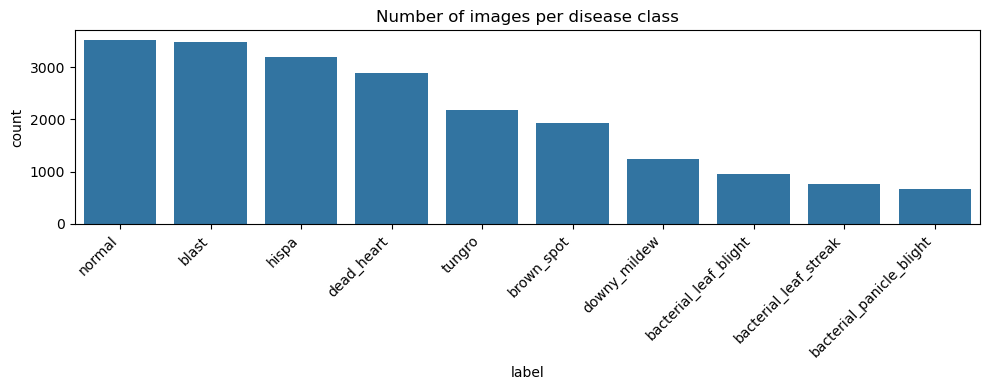

In [4]:
# Visualise Class Distribution
plt.figure(figsize=(10,4))
sns.countplot(data=df, x="label", order=df["label"].value_counts().index)
plt.xticks(rotation=45, ha="right")
plt.title("Number of images per disease class")
plt.tight_layout()
plt.show()

C:\Users\Reino Yuris\AppData\Local\Temp\ipykernel_33448\2513489872.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(1, random_state=42))


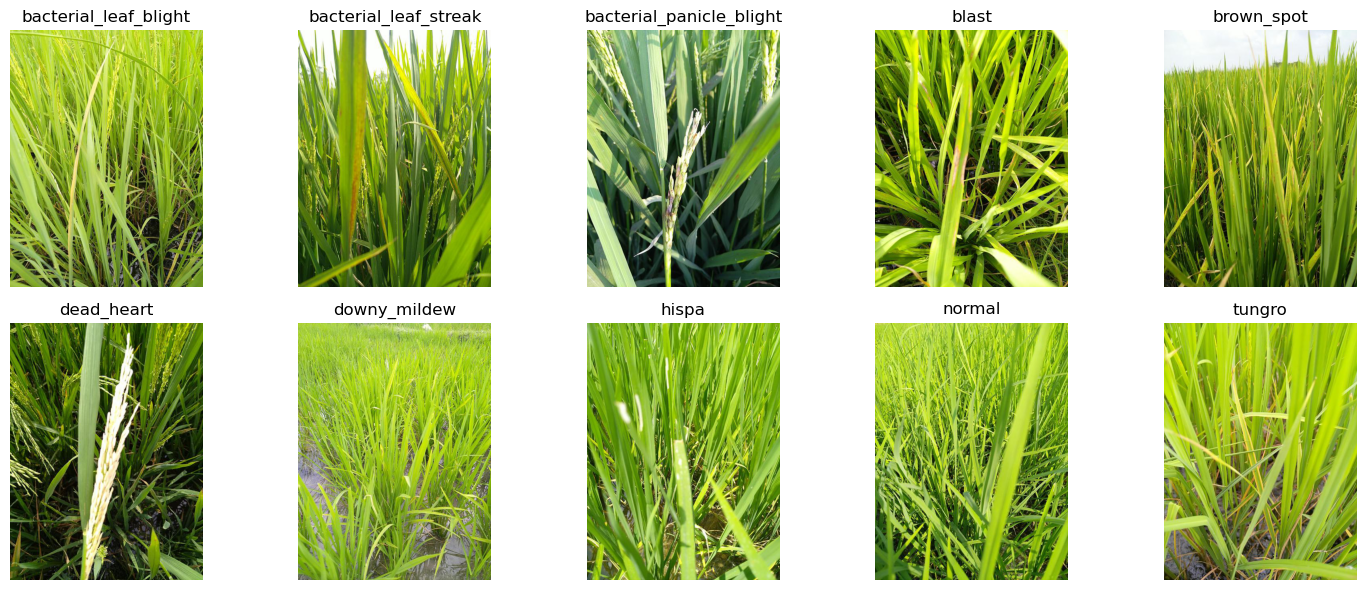

In [5]:
# Show samples images per class
samples = (
    df
    .groupby("label")
    .apply(lambda g: g.sample(1, random_state=42))
    .reset_index(drop=True)
)

n = len(samples)
cols = 5
rows = (n + cols - 1)//cols
plt.figure(figsize=(cols*3, rows*3))
for i, row in samples.iterrows():
    img = plt.imread(row.filepath)
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis("off")
plt.tight_layout()
plt.show()


### Preprocessing

In [6]:
# Stratified split: 80 % train, 10 % val, 10 % test
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Train: 16651 Val: 2081 Test: 2082


In [7]:
import shutil

def build_folder(split_df, split_name):
    base = pathlib.Path(f"data/{split_name}")
    for _, r in split_df.iterrows():
        dst = base / r.label
        dst.mkdir(parents=True, exist_ok=True)
        shutil.copy2(r.filepath, dst)

for df_split, name in [(train_df,"train"), (val_df,"val"), (test_df,"test")]:
    build_folder(df_split, name)

print("Folder structure ready under data/{train,val,test}")     

Folder structure ready under data/{train,val,test}


In [8]:
# Define PyTorch transforms
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [9]:
train_ds = datasets.ImageFolder("data/train", transform=train_tf)
val_ds   = datasets.ImageFolder("data/val",   transform=val_tf)
test_ds  = datasets.ImageFolder("data/test",  transform=val_tf)

train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True
)
val_dl = torch.utils.data.DataLoader(
    val_ds, batch_size=32, num_workers=4, pin_memory=True
)
test_dl = torch.utils.data.DataLoader(
    test_ds, batch_size=32, num_workers=4, pin_memory=True
)

print("Classes:", train_ds.classes)
print("Batches per epoch:", len(train_dl))

Classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']
Batches per epoch: 312


### Modelling

#### 1. MobileNet V2

In [10]:
from torch import nn, optim
from torchmetrics import F1Score
import torchvision.models as models

# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Choose number of classes
num_classes = len(train_ds.classes)

In [11]:
# 3. Build MobileNet V2
model = models.mobilenet_v2(weights="IMAGENET1K_V1")
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)

In [12]:
# 4. Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(weight=torch.tensor([
    1.0 for _ in range(num_classes)
], device=device))            # you can plug in real class weights here
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# 5. Metric
f1_metric = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

In [13]:
# 6. Training & validation loops
def train_epoch():
    model.train()
    running_loss = 0.0
    f1_metric.reset()
    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        f1_metric.update(logits.softmax(dim=1), labels)
    epoch_loss = running_loss / len(train_dl.dataset)
    epoch_f1   = f1_metric.compute().item()
    return epoch_loss, epoch_f1

def validate_epoch():
    model.eval()
    running_loss = 0.0
    f1_metric.reset()
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            running_loss += loss.item() * imgs.size(0)
            f1_metric.update(logits.softmax(dim=1), labels)
    epoch_loss = running_loss / len(val_dl.dataset)
    epoch_f1   = f1_metric.compute().item()
    return epoch_loss, epoch_f1

In [14]:
# 7. Full training loop with early stopping
best_val_f1 = 0.0
patience, trigger = 5, 0

for epoch in range(1, 21):
    train_loss, train_f1 = train_epoch()
    val_loss, val_f1     = validate_epoch()
    scheduler.step()

    print(f"Epoch {epoch:02d}  "
          f"Train loss {train_loss:.3f}  Train F1 {train_f1:.3f}  "
          f"Val loss {val_loss:.3f}  Val F1 {val_f1:.3f}")

    # check for improvement
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        trigger = 0
        torch.save(model.state_dict(), "best_mobilenetv2.pth")
    else:
        trigger += 1
        if trigger >= patience:
            print("No improvement for 5 epochs, stopping early.")
            break

print("Best Val F1:", best_val_f1)

d:\Anaconda\envs\ML_iup\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

### Implement Best Model 

In [ ]:
# Load the best model
model = models.mobilenet_v2(pretrained=False)  
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load("best_mobilenetv2.pth"))  # Load the best model
model = model.to(device)  # CPU
model.eval()  # Set the model to evaluation mode


d:\Anaconda\envs\ML_iup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\ML_iup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### Testing

In [ ]:
from sklearn.metrics import classification_report

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Evaluate on the test set
with torch.no_grad():  # No need to track gradients during inference
    for imgs, labels in test_dl:  # test_dl is your DataLoader for test data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)  # Get the predicted class (max probability)

        # Store the results
        all_preds.extend(preds.cpu().numpy())  # Move to CPU for metric calculation
        all_labels.extend(labels.cpu().numpy())  # Same here for true labels

# Generate a classification report
print("Classification Report on Test Set:")
print(classification_report(all_labels, all_preds, target_names=test_ds.classes))


Classification Report on Test Set:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.99      0.91      0.95        88
   bacterial_leaf_streak       0.96      0.97      0.96        69
bacterial_panicle_blight       0.96      0.97      0.96        66
                   blast       0.97      0.95      0.96       326
              brown_spot       0.95      0.98      0.96       187
              dead_heart       1.00      0.99      0.99       271
            downy_mildew       0.93      0.86      0.89       119
                   hispa       0.96      0.96      0.96       303
                  normal       0.95      0.98      0.97       337
                  tungro       0.94      0.96      0.95       207

                accuracy                           0.96      1973
               macro avg       0.96      0.95      0.96      1973
            weighted avg       0.96      0.96      0.96      1973



In [ ]:
# Initialize F1 metric
f1_metric = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

# Update F1 metric with the test set results
f1_metric.update(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))

# Compute the final F1 score
test_f1 = f1_metric.compute().item()
print(f"Test F1 Score: {test_f1:.4f}")

Test F1 Score: 0.9556
